In [1]:
# -*- coding: utf-8 -*-
# @ Time    : 2024/10/06
# @ Author : zlz.bit.pro@gmail.com
# @ Desc: Example to determine the insert operations in different drfit setting in 

# set workspace to the root of the project
import os
workspace_path = '../..'
os.chdir(workspace_path)
print("Current workspace:", os.getcwd())

Current workspace: /users/lingze/neurbench


In [2]:
import numpy as np
from neurbench.index.util import load_key_set, KeyType, save_file
from neurbench.index.bench import KeySetBinEncoder, sample_bulkloading_keyset
from neurbench.drift import find_q

In [3]:
# load book_fb_200M key set
keyset_file_path = "/users/lingze/neurbench/data/keys/books_200M_unique_uint64"
data = load_key_set(keyset_file_path)

In [4]:
# get data type and check whether unique
data_type = KeyType.resolve_type_from_filename(keyset_file_path)
# set to uint64, currently cann't execute uint32 exp in benchmark code
print(data_type)
flag = len(np.unique(data)) == len(data)
print("Data is unique:", flag)

KeyType.UINT64
Data is unique: True


Max value: 2147483646
Min value: 0


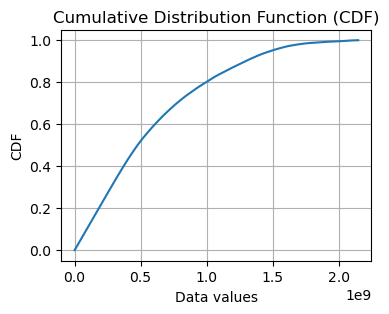

In [9]:
"""plot the data Cumulative Distribution Function (CDF)
"""
max_value = np.max(data)
min_value = np.min(data)
print("Max value:", max_value)
print("Min value:", min_value)
KeySetBinEncoder.plot_cdf(
    data,
    min_value=min_value,
    max_value=max_value,
    offset= 1e8,
)

In [10]:
"""abnormal key filter
# before we get the data distribution of key set
# we need to filter out the abnormal keys
"""
keys, removed_key = KeySetBinEncoder.filter_abnormal_values(data, "IQR", verbose = True)
print("Remove rate:", len(removed_key) / len(data))

Filtered 1477750 values, [145665614 / 147143364]
Remove rate: 0.010042926570579152


Total number of bins: 220


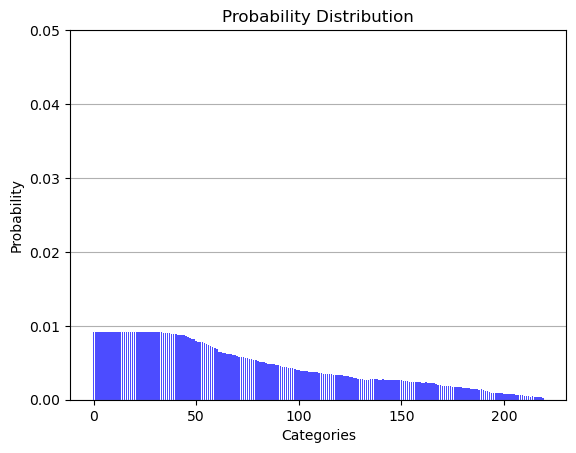

In [13]:
"""Bin the key set, get the distribution of key set
heuristically choose the bin size.
"""
bin_width_offset = 23
bin_idxs, prob, bin_idx_to_keys = KeySetBinEncoder.bin_keyset_to_distribution(
    keys,
    bin_width_offset=bin_width_offset,
    verbose=True
)
KeySetBinEncoder.plot_probability_distribution(prob, bin_idxs.tolist())

In [14]:
min_bin_num = int(np.min(bin_idxs))
max_bin_num = int(np.max(bin_idxs))
prob_dict = {}

for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = prob[i]

x = [ i for i in range(min_bin_num, max_bin_num+1)]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

0.02


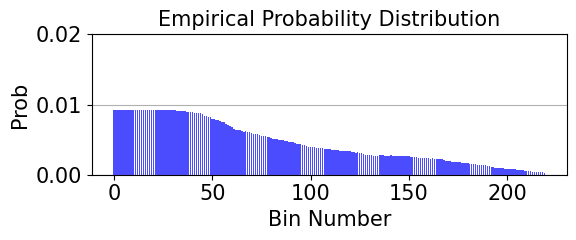

In [18]:
# draw the estimated distribution and store the figure
import matplotlib.pyplot as plt
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 50) / 50
# rounded 0.05
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.bar(labels, y, color='blue', alpha=0.7)
ax.set_xlabel('Bin Number', fontsize = 15)
ax.set_ylabel('Prob', fontsize = 15)
ax.set_title('Empirical Probability Distribution', fontsize = 15)
print(rounded_max_value)
ax.set_ylim(0, 0.02)  # Set y-axis limits from 0 to 1
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/books_200M_uint64_distribution.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

---
### Drift 0.1

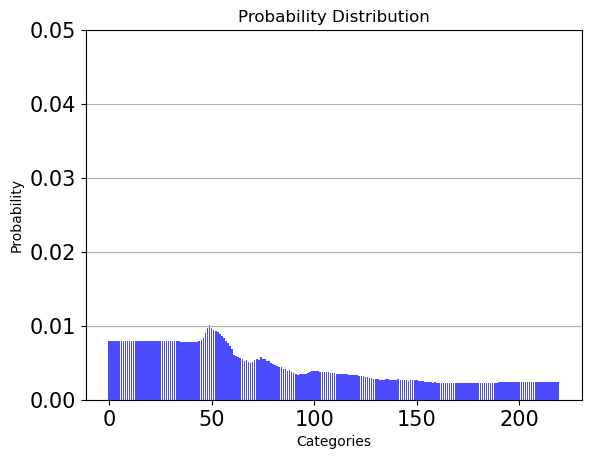

In [86]:
# Drift setting alpha = 0.1, unform drift
init_prob = find_q(prob, 0.1, skewed=False)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [87]:
bulkloading_n = int(0.5 * len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding the number of keys in bin 192, sample_n: 170665, bound_n: 166695
Exceeding the number of keys in bin 193, sample_n: 171178, bound_n: 153408
Exceeding the number of keys in bin 194, sample_n: 171822, bound_n: 137313
Exceeding the number of keys in bin 195, sample_n: 171723, bound_n: 139743
Exceeding the number of keys in bin 196, sample_n: 171999, bound_n: 132990
Exceeding the number of keys in bin 197, sample_n: 171831, bound_n: 137099
Exceeding the number of keys in bin 198, sample_n: 171949, bound_n: 134204
Exceeding the number of keys in bin 199, sample_n: 172336, bound_n: 124899
Exceeding the number of keys in bin 200, sample_n: 172737, bound_n: 115466
Exceeding the number of keys in bin 201, sample_n: 172591, bound_n: 118872
Exceeding the number of keys in bin 202, sample_n: 172893, bound_n: 111872
Exceeding the number of keys in bin 203, sample_n: 172974, bound_n: 110002
Exceeding the number of keys in bin 204, sample_n: 173045, bound_n: 108385
Exceeding the number of k

Total number of bins: 220


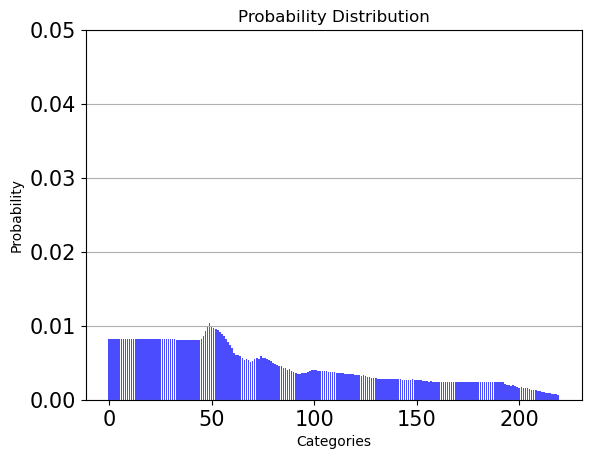

In [88]:
"""Bin the key set, get the distribution of key set
heuristically choose the bin size.
"""
bin_width_offset = 23
bin_idxs, ini_prob, _ = KeySetBinEncoder.bin_keyset_to_distribution(
    np.array(bulkloading_keys),
    bin_width_offset=bin_width_offset,
    verbose=True
)
KeySetBinEncoder.plot_probability_distribution(ini_prob, bin_idxs.tolist())

In [89]:
inserted_keys = np.setdiff1d(data, bulkloading_keys)
print("Insert number of records:", len(inserted_keys))
print("Insert ratio:", len(inserted_keys) / len(data))
# print bulkloading key CDF

Insert number of records: 76382323
Insert ratio: 0.5191013778915643


In [90]:

# draw the picture of the bulkloading key 
prob_dict = {}
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = ini_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

0.1


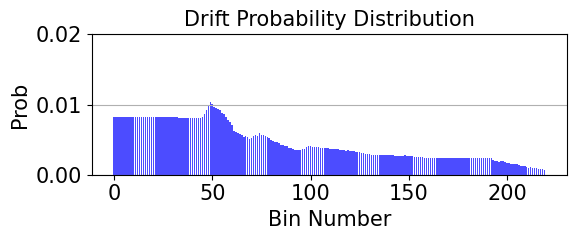

In [91]:
# draw the estimated distribution and store the figure
import matplotlib.pyplot as plt
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 10) / 10
# rounded 0.05
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.bar(labels, y, color='blue', alpha=0.7)
ax.set_xlabel('Bin Number', fontsize = 15)
ax.set_ylabel('Prob', fontsize = 15)
ax.set_title('Drift Probability Distribution', fontsize = 15)
print(rounded_max_value)
ax.set_ylim(0, 0.02)  # Set y-axis limits from 0 to 1
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/books_200M_uint64_distribution_drift_01.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

In [92]:
workload_dir_path = "/users/lingze/neurbench/data/workload/books_200M_uint64_drift_01"
os.makedirs(workload_dir_path, exist_ok=True)

inserted_keys = np.array(inserted_keys, dtype=data_type.to_numpy_type())
bulkloading_keys = np.array(bulkloading_keys, dtype=data_type.to_numpy_type())

bulkloading_keyset_file_path = os.path.join(workload_dir_path, "init_keys_uint64")
insert_keyset_file_path = os.path.join(workload_dir_path, "insert_keys_uint64")
save_file(bulkloading_keyset_file_path, bulkloading_keys, data_type)
save_file(insert_keyset_file_path, inserted_keys, data_type)

---
### Drift 0.3

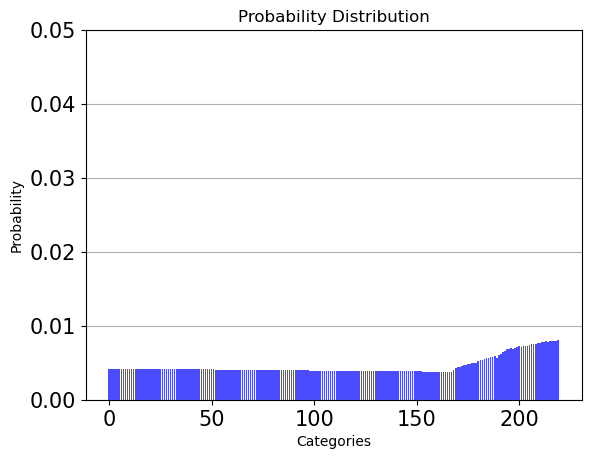

In [37]:
# Drift setting alpha = 0.3, unform drift
init_prob = find_q(prob, 0.3, skewed=False)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [38]:
bulkloading_n = int(0.5 * len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding the number of keys in bin 169, sample_n: 314114, bound_n: 283503
Exceeding the number of keys in bin 170, sample_n: 322665, bound_n: 277220
Exceeding the number of keys in bin 171, sample_n: 321438, bound_n: 278117
Exceeding the number of keys in bin 172, sample_n: 331439, bound_n: 270834
Exceeding the number of keys in bin 173, sample_n: 338593, bound_n: 265653
Exceeding the number of keys in bin 174, sample_n: 341782, bound_n: 263347
Exceeding the number of keys in bin 175, sample_n: 348300, bound_n: 258636
Exceeding the number of keys in bin 176, sample_n: 354595, bound_n: 254083
Exceeding the number of keys in bin 177, sample_n: 359959, bound_n: 250196
Exceeding the number of keys in bin 178, sample_n: 360819, bound_n: 249572
Exceeding the number of keys in bin 179, sample_n: 360834, bound_n: 249561
Exceeding the number of keys in bin 180, sample_n: 382516, bound_n: 233712
Exceeding the number of keys in bin 181, sample_n: 393885, bound_n: 225278
Exceeding the number of k

Total number of bins: 220


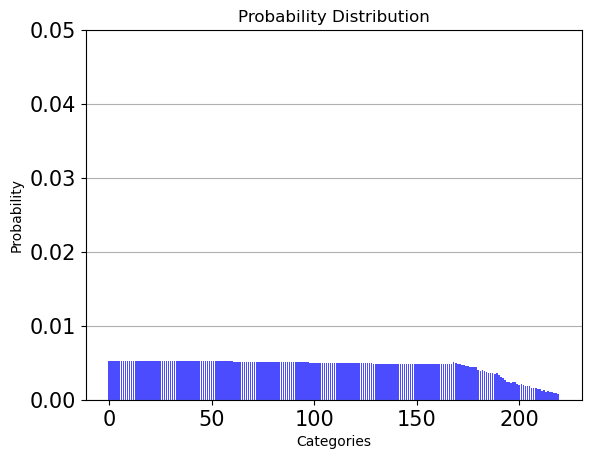

In [39]:
"""Bin the key set, get the distribution of key set
heuristically choose the bin size.
"""
bin_width_offset = 23
bin_idxs, ini_prob, _ = KeySetBinEncoder.bin_keyset_to_distribution(
    np.array(bulkloading_keys),
    bin_width_offset=bin_width_offset,
    verbose=True
)
KeySetBinEncoder.plot_probability_distribution(ini_prob, bin_idxs.tolist())

In [40]:
inserted_keys = np.setdiff1d(data, bulkloading_keys)
print("Insert number of records:", len(inserted_keys))
print("Insert ratio:", len(inserted_keys) / len(data))
# print bulkloading key CDF

Insert number of records: 89920257
Insert ratio: 0.6111064376644264


In [41]:

# draw the picture of the bulkloading key 
prob_dict = {}
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = ini_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

0.1


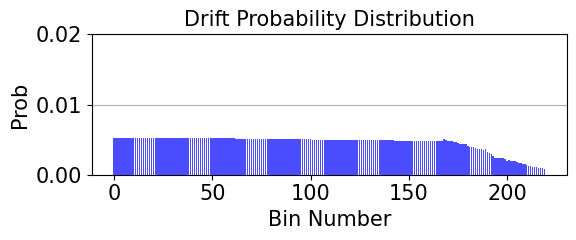

In [42]:
# draw the estimated distribution and store the figure
import matplotlib.pyplot as plt
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 10) / 10
# rounded 0.05
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.bar(labels, y, color='blue', alpha=0.7)
ax.set_xlabel('Bin Number', fontsize = 15)
ax.set_ylabel('Prob', fontsize = 15)
ax.set_title('Drift Probability Distribution', fontsize = 15)
print(rounded_max_value)
ax.set_ylim(0, 0.02)  # Set y-axis limits from 0 to 1
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/books_200M_uint64_distribution_drift_03.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

In [43]:
workload_dir_path = "/users/lingze/neurbench/data/workload/books_200M_uint64_drift_03"
os.makedirs(workload_dir_path, exist_ok=True)

inserted_keys = np.array(inserted_keys, dtype=data_type.to_numpy_type())
bulkloading_keys = np.array(bulkloading_keys, dtype=data_type.to_numpy_type())

bulkloading_keyset_file_path = os.path.join(workload_dir_path, "init_keys_uint64")
insert_keyset_file_path = os.path.join(workload_dir_path, "insert_keys_uint64")
save_file(bulkloading_keyset_file_path, bulkloading_keys, data_type)
save_file(insert_keyset_file_path, inserted_keys, data_type)

---
### Drift 0.5

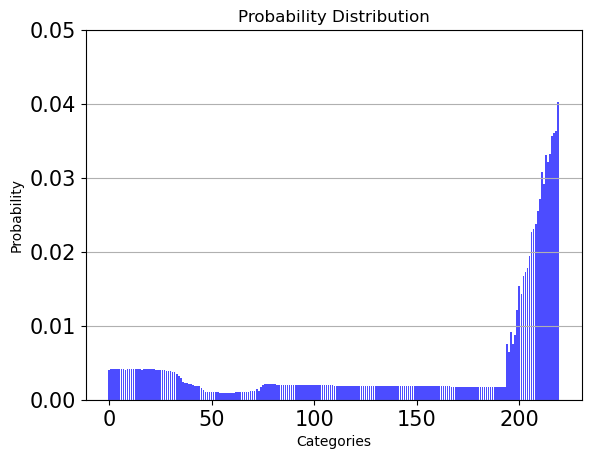

In [71]:
# Drift setting alpha = 0.5, unform drift
init_prob = find_q(prob, 0.5, skewed=False)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [72]:
bulkloading_n = int(0.5*len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding the number of keys in bin 194, sample_n: 544478, bound_n: 137313
Exceeding the number of keys in bin 195, sample_n: 466504, bound_n: 139743
Exceeding the number of keys in bin 196, sample_n: 670493, bound_n: 132990
Exceeding the number of keys in bin 197, sample_n: 551034, bound_n: 137099
Exceeding the number of keys in bin 198, sample_n: 636252, bound_n: 134204
Exceeding the number of keys in bin 199, sample_n: 886222, bound_n: 124899
Exceeding the number of keys in bin 200, sample_n: 1124797, bound_n: 115466
Exceeding the number of keys in bin 201, sample_n: 1039508, bound_n: 118872
Exceeding the number of keys in bin 202, sample_n: 1214169, bound_n: 111872
Exceeding the number of keys in bin 203, sample_n: 1260496, bound_n: 110002
Exceeding the number of keys in bin 204, sample_n: 1300484, bound_n: 108385
Exceeding the number of keys in bin 205, sample_n: 1417484, bound_n: 103644
Exceeding the number of keys in bin 206, sample_n: 1649211, bound_n: 94242
Exceeding the numbe

Total number of bins: 220


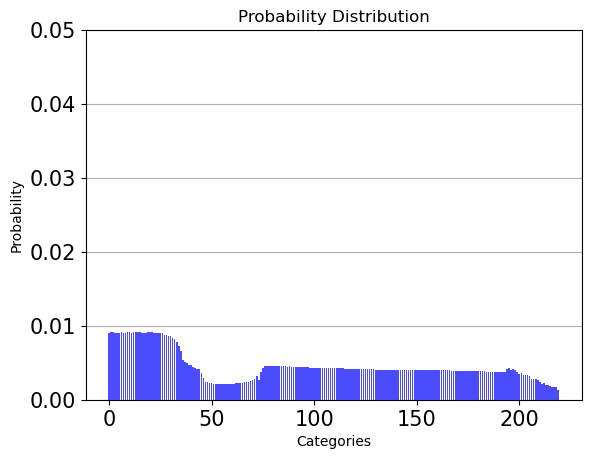

In [73]:
"""Bin the key set, get the distribution of key set
heuristically choose the bin size.
"""
bin_width_offset = 23
bin_idxs, ini_prob, _ = KeySetBinEncoder.bin_keyset_to_distribution(
    np.array(bulkloading_keys),
    bin_width_offset=bin_width_offset,
    verbose=True
)
KeySetBinEncoder.plot_probability_distribution(ini_prob, bin_idxs.tolist())

In [74]:
inserted_keys = np.setdiff1d(data, bulkloading_keys)
print("Insert number of records:", len(inserted_keys))
print("Insert ratio:", len(inserted_keys) / len(data))
# print bulkloading key CDF

Insert number of records: 114218142
Insert ratio: 0.7762371261268703


In [75]:

# draw the picture of the bulkloading key 
prob_dict = {}
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = ini_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

0.1


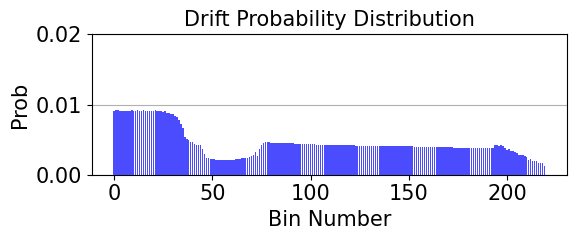

In [76]:
# draw the estimated distribution and store the figure
import matplotlib.pyplot as plt
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 10) / 10
# rounded 0.05
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.bar(labels, y, color='blue', alpha=0.7)
ax.set_xlabel('Bin Number', fontsize = 15)
ax.set_ylabel('Prob', fontsize = 15)
ax.set_title('Drift Probability Distribution', fontsize = 15)
print(rounded_max_value)
ax.set_ylim(0, 0.02)  # Set y-axis limits from 0 to 1
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/books_200M_uint64_distribution_drift_05.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

In [77]:
workload_dir_path = "/users/lingze/neurbench/data/workload/books_200M_uint64_drift_05"
os.makedirs(workload_dir_path, exist_ok=True)

inserted_keys = np.array(inserted_keys, dtype=data_type.to_numpy_type())
bulkloading_keys = np.array(bulkloading_keys, dtype=data_type.to_numpy_type())

bulkloading_keyset_file_path = os.path.join(workload_dir_path, "init_keys_uint64")
insert_keyset_file_path = os.path.join(workload_dir_path, "insert_keys_uint64")
save_file(bulkloading_keyset_file_path, bulkloading_keys, data_type)
save_file(insert_keyset_file_path, inserted_keys, data_type)

---
### Drift 0.7

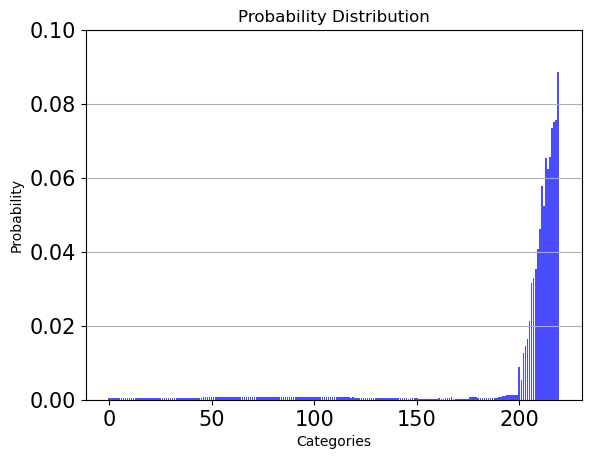

In [78]:
# Drift setting alpha = 0.7, unform drift
init_prob = find_q(prob, 0.7, skewed=False)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [79]:
bulkloading_n = int( 1 * len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding the number of keys in bin 194, sample_n: 179556, bound_n: 137313
Exceeding the number of keys in bin 195, sample_n: 175538, bound_n: 139743
Exceeding the number of keys in bin 196, sample_n: 186707, bound_n: 132990
Exceeding the number of keys in bin 197, sample_n: 179909, bound_n: 137099
Exceeding the number of keys in bin 198, sample_n: 184698, bound_n: 134204
Exceeding the number of keys in bin 199, sample_n: 200090, bound_n: 124899
Exceeding the number of keys in bin 200, sample_n: 1293650, bound_n: 115466
Exceeding the number of keys in bin 201, sample_n: 772833, bound_n: 118872
Exceeding the number of keys in bin 202, sample_n: 1845537, bound_n: 111872
Exceeding the number of keys in bin 203, sample_n: 2133678, bound_n: 110002
Exceeding the number of keys in bin 204, sample_n: 2383390, bound_n: 108385
Exceeding the number of keys in bin 205, sample_n: 3118542, bound_n: 103644
Exceeding the number of keys in bin 206, sample_n: 4589942, bound_n: 94242
Exceeding the number

Total number of bins: 220


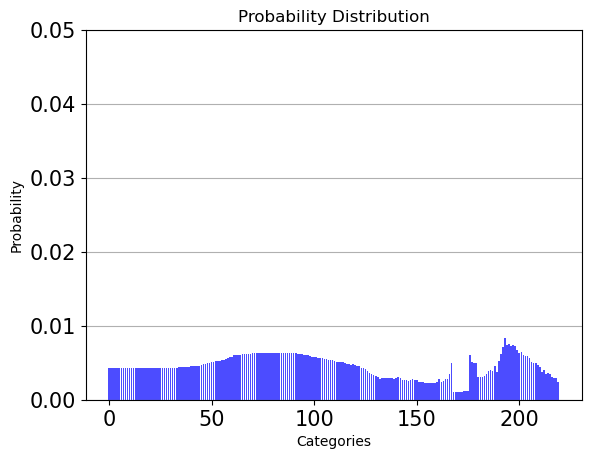

In [80]:
"""Bin the key set, get the distribution of key set
heuristically choose the bin size.
"""
bin_width_offset = 23
bin_idxs, ini_prob, _ = KeySetBinEncoder.bin_keyset_to_distribution(
    np.array(bulkloading_keys),
    bin_width_offset=bin_width_offset,
    verbose=True
)
KeySetBinEncoder.plot_probability_distribution(ini_prob, bin_idxs.tolist())

In [81]:
inserted_keys = np.setdiff1d(data, bulkloading_keys)
print("Insert number of records:", len(inserted_keys))
print("Insert ratio:", len(inserted_keys) / len(data))
# print bulkloading key CDF

Insert number of records: 128689558
Insert ratio: 0.8745862164738873


In [82]:

# draw the picture of the bulkloading key 
prob_dict = {}
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = ini_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

0.1


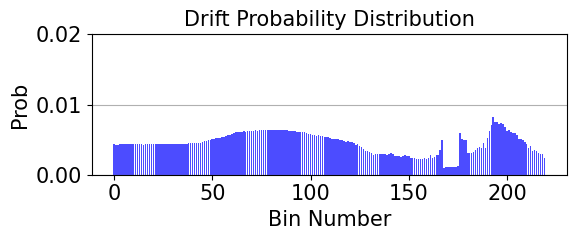

In [84]:
# draw the estimated distribution and store the figure
import matplotlib.pyplot as plt
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 10) / 10
# rounded 0.05
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.bar(labels, y, color='blue', alpha=0.7)
ax.set_xlabel('Bin Number', fontsize = 15)
ax.set_ylabel('Prob', fontsize = 15)
ax.set_title('Drift Probability Distribution', fontsize = 15)
print(rounded_max_value)
ax.set_ylim(0, 0.02)  # Set y-axis limits from 0 to 1
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/books_200M_uint64_distribution_drift_07.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

In [85]:
workload_dir_path = "/users/lingze/neurbench/data/workload/books_200M_uint64_drift_07"
os.makedirs(workload_dir_path, exist_ok=True)

inserted_keys = np.array(inserted_keys, dtype=data_type.to_numpy_type())
bulkloading_keys = np.array(bulkloading_keys, dtype=data_type.to_numpy_type())

bulkloading_keyset_file_path = os.path.join(workload_dir_path, "init_keys_uint64")
insert_keyset_file_path = os.path.join(workload_dir_path, "insert_keys_uint64")
save_file(bulkloading_keyset_file_path, bulkloading_keys, data_type)
save_file(insert_keyset_file_path, inserted_keys, data_type)